# Second Analysis

#### Clusters and topics

#### Using Spacy and K-Means to analyze the tokens and try to group the contained sentences in each review.

Good tutorials and other texts

- Tutorial: Text Classification in Python Using spaCy
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

## Importing all needed packages

#### Command to install **spaCy** package: ***pip install spacy***

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import spacy
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import seaborn as sns
import re
from pprint import pprint

## Loading the sentences of the CSV file.

In [2]:
nlp = spacy.load('pt_core_news_lg') # https://spacy.io/models/pt#pt_core_news_lg

In [3]:
df = pd.read_csv( 
    './datasets/sentences.csv',
    encoding = 'UTF8',
    sep = ';');
df.head()

,book_id,review_id,review_rating,sentence
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ..."
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176751 entries, 0 to 176750
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   book_id        176751 non-null  int64 
 1   review_id      176751 non-null  object
 2   review_rating  176751 non-null  int64 
 3   sentence       176750 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.4+ MB


In [5]:
df.iloc[0]['sentence']

'Sabe todos aqueles livros que ensinam você a criar uma agenda para controle de gastos contendo tudo que você gasta durante determinado período de tempo e que você nunca consegue terminar o tal método?'

In [6]:
doc = nlp( df.iloc[0]['sentence'] )
tokens = [token.text for token in doc]
print(tokens)

['Sabe', 'todos', 'aqueles', 'livros', 'que', 'ensinam', 'você', 'a', 'criar', 'uma', 'agenda', 'para', 'controle', 'de', 'gastos', 'contendo', 'tudo', 'que', 'você', 'gasta', 'durante', 'determinado', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'consegue', 'terminar', 'o', 'tal', 'método', '?']


In [7]:
tokens = [token.lemma_ for token in doc]
print(tokens)

['Sabe', 'todo', 'aquele', 'livro', 'que', 'ensinar', 'você', 'o', 'criar', 'umar', 'agendar', 'parir', 'controlo', 'de', 'gasto', 'conter', 'tudo', 'que', 'você', 'gasto', 'durante', 'determinar', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'conseguir', 'terminar', 'o', 'tal', 'método', '?']


## Analysis of the sentences sizes

In [8]:
df['sentence_size'] = [ len(str(sentence)) for sentence in df['sentence'] ]
df

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...,200
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...,163
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ...",123
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...,55
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...,225
...,...,...,...,...,...
176746,8544106595,RQUIEDP9RU8GN,5,"Uma obra que toca nos seus maiores pesadelos,m...",302
176747,8544106595,R28THF88K7GE5S,5,"Leve,pesado,forte,suave,lindo,feio e todas as ...",59
176748,8544106595,R28THF88K7GE5S,5,"Lindo,lindo,lindo.",18
176749,8544106595,R28THF88K7GE5S,5,"Amei,comi,bebi cada palavra.",28


In [9]:
df['sentence_size'].describe()

count    176751.000000
mean         68.294205
std          62.576959
min           1.000000
25%          25.000000
50%          52.000000
75%          93.000000
max        2080.000000
Name: sentence_size, dtype: float64

## Analysis of top sentences

In [10]:
df['sentence'].value_counts()

                                                                                1116
Muito bom                                                                        584
Recomendo.                                                                       561
!                                                                                514
Muito bom!                                                                       459
                                                                                ... 
Muito bom, fácil a leitura e bem diferente dos filmes hehehehe                     1
O Senhor do anéis completo.                                                        1
Gostei tanto que comprei em seguida o box                                          1
História muito cativante e divertida de se ler.                                    1
A poesia de  Amanda  é visceral ,intensa e tão próxima de todas as mulheres.       1
Name: sentence, Length: 138605, dtype: int64

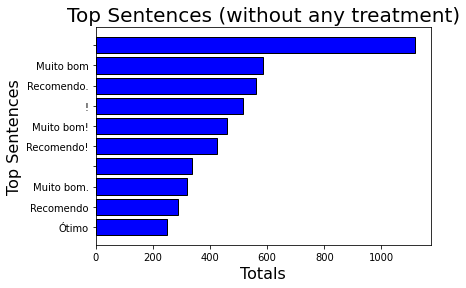

In [11]:
topSentencesLimit = 10
topSentences = df['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = df['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (without any treatment)', fontsize=20 )
plt.show()

#### Function: cleanSentence()

In [12]:
def cleanSentence( sentence ):
    
    sentence = str( sentence )
    sentence = re.sub('[\,\.\!\?\%\'\(\)\,\-\_\“\”\●\♥\d\/\$\&\`\*\+\❞\°\–\…👏💪📸😁😍😘😚🙂🥰🥺❤🏻🏾💃💖😉😔😲✨💗💚🔝😊😕😻🧐🤧]', '', sentence)
    sentence = re.sub('\sque\s|\scom\s|\sao\s|\stem\s', ' ', sentence)
    sentence = re.sub('\sum\s|\suma\s|\suns\s|\sumas\s|\so\s|\sa\s|\sos\s|\sas\s', ' ', sentence)
    sentence = re.sub('\sde\s|\sdo\s|\sda\s|\sdes\s|\sdos\s|\sdas\s|\sem\s|\sno\s|\sna\s|\snos\s|\snas\s', ' ', sentence)
    sentence = re.sub('\slivro\s|\slivros\s|\spara\s|\smuito\s|\seu\s|\smas\s|\smais\s|\spessoas\s', ' ', sentence)
    sentence = re.sub('\scomo\s|\sse\s|\studo\s|\smesmo\s|\sme\s|\ssobre\s', ' ', sentence)
    sentence = re.sub('\squem\s|\spor\s|\stodos\s|\se\s|\é\s', ' ', sentence)
    sentence = re.sub('\smuito\s|\sele\s|\smeu\s|\sler\s|\sesse\s|\sessa\s|\sesses\s|\sessas\s|\scada\s|\spela\s', ' ', sentence)
    sentence = re.sub('\slivro\s|\ster\s|\ssua\s|\sser\s|\spra\s|\svocê\s|\sum\s|\ssuper\s|\sjá\s|\ssão\s|\sou\s|\shistória\s', ' ', sentence)
    sentence = re.sub('\s\s', ' ', sentence)
    
    sentence = sentence.lower()
    
    return sentence

In [13]:
sentences = df['sentence'].tolist()
cleanedSentences = [cleanSentence( sentence ) for sentence in sentences]
dfTopSentences = df
dfTopSentences['sentence'] = cleanedSentences
dfTopSentences['sentence'].head()

0    sabe aqueles ensinam criar agenda controle gas...
1    ou daqueles termina leitura sentindo vida vai ...
2    você não vai encontrar setup milagroso algum t...
3             basicamente este conta verdades dinheiro
4    mostra detalhes forma tão direta bem escrita a...
Name: sentence, dtype: object

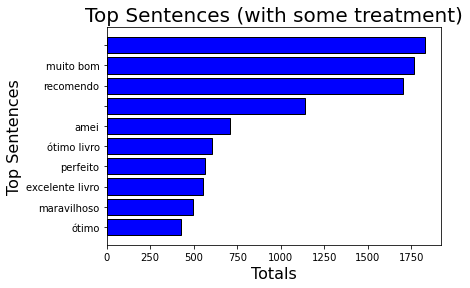

In [14]:
topSentencesLimit = 10
topSentences = dfTopSentences['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = dfTopSentences['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (with some treatment)', fontsize=20 )
plt.show()

### Repeated Sentences

In [15]:
total = len(dfTopSentences['sentence'])
values = dfTopSentences['sentence'].value_counts()[:total]
sentences = dfTopSentences['sentence'].value_counts()[:total].index

In [16]:
repeatedSentences = list()
for i in range(0, len(sentences)):
    # print( f'{sentence[i]} - {values[i]}' )
    if values[i] > 1:
        repeatedSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(repeatedSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[:showTotal]:
        
    print( f"{item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[-showTotal:]:
        
    print( f"{item['sentence']} - {item['value']}" )

Total of results: 11539
--------------------------

First 10 results
--------------------------

 - 1830
muito bom - 1765
recomendo - 1702
  - 1138
amei - 709
ótimo livro - 604
perfeito - 566
excelente livro - 553
maravilhoso - 498
ótimo - 426


Last 10 results
--------------------------

se superou proteção livro - 2
meu deus céu simplesmente tô apaixonada concerteza virou favoritas vida série - 2
o melhor livro da sériee fiquei feliz minha entrega antes tempo previsto bem embaladinho cuidado - 2
você sempre vai querer saber vem depois - 2
como falar desse perfeito - 2
após relutar acabei comprando dois primeiros saga bringertons confesso faltou quê antony decepcionou pouco nesse tratar história - 2
recomendo fortíssimo toda sérielivro  o visconde amava trata anthony filho velho herda título todas propriedades riqueza prestígio por causa disso acha precisa casar beladisputadaperfeita donzela temporada - 2
mas breve farei leitura terceiro espero gostar mais - 2
maravilhoso entrega rápi

### Unique Sentences

In [17]:
uniqueSentences = list()
for i in range(0, len(sentences)):
    
    if values[i] == 1:
        uniqueSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(uniqueSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[:showTotal]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[-showTotal:]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

Total of results: 119411
--------------------------

First 10 results
--------------------------

>>> gostaria miles tate sam porém terminou forma linda - 1
>>> uma pena não veio marcador páginas estava descrito - 1
>>> livro:perfeitocapa dura vem marcador filete - 1
>>> sempre gostei coralinelogo não decepcionou nem pouco - 1
>>> as ilustrações completam forma ímpar - 1
>>> o páginas amarelas boa diagramação - 1
>>> rápida antes prazo - 1
>>> fora isso entrega foi rápida estava estimando semana vem chegou hoje - 1
>>> o incrivelmente lindo obra arte gosto além ótima - 1
>>> fascinado pelo acabamento qualidade sem falar historia bacana - 1


Last 10 results
--------------------------

>>> muito bom design diagramação ilustrações - 1
>>> a escrita o hobbit capa sai passar dedos - 1
>>> a qualidade péssima - 1
>>> veio sem pôster - 1
>>> o veio alguns cortes papel nada grave - 1
>>> demorou pouco chegar capa veio estragada - 1
>>> mas infelizmente veio amassado horrível contra capa - 1
>

### A good question to future investigation:

We can relate these top sentences with users? Maybe the top sentences belongs to the same group of people...**

But we need to observe privacy before this...**

## Building a Bag of Words (BoW) with the words of the sentences.

#### Get only unique sentences to analyse

In [18]:
tempDf = df

In [19]:
tempDf['sentence'] = [cleanSentence(sentence) for sentence in tempDf['sentence']]

In [20]:
len(tempDf)

176751

In [21]:
uniqueSentencesList = [ item['sentence'] for item in uniqueSentences ]
# uniqueSentencesList

In [22]:
tempDf = tempDf[ tempDf[ 'sentence' ].isin(uniqueSentencesList) ]

In [23]:
len(tempDf)

104180

In [24]:
tempDf

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200
1,8595081530,RM0NBXMBSU4M3,4,ou daqueles termina leitura sentindo vida vai ...,163
2,8595081530,RM0NBXMBSU4M3,4,você não vai encontrar setup milagroso algum t...,123
3,8595081530,RM0NBXMBSU4M3,4,basicamente este conta verdades dinheiro,55
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma tão direta bem escrita a...,225
...,...,...,...,...,...
176745,8544106595,R2QICSES0F3VIR,5,amazon surpreendeu comprarei novo,46
176746,8544106595,RQUIEDP9RU8GN,5,uma obra toca seus maiores pesadelosmas apesar...,302
176747,8544106595,R28THF88K7GE5S,5,levepesadofortesuavelindofeio todas fases lua,59
176748,8544106595,R28THF88K7GE5S,5,lindolindolindo,18


#### Total of selected sentences in partialDf

In [25]:
linesTotal = 1000

In [26]:
# partialDf = tempDf.iloc[ :linesTotal ]
partialDf = tempDf.sample( linesTotal )

In [27]:
partialDf.head()

,book_id,review_id,review_rating,sentence,sentence_size
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,67
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,152
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,106
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,65
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,70


In [28]:
partialDf.tail()

,book_id,review_id,review_rating,sentence,sentence_size
161625,8532649963,R3QX1U7096XL7N,4,aconselho junto outras obras autor psicopolíti...,121
48478,8539004119,R2UYDY9BZP79FE,5,o maravilhoso foi entregue dentro prazo,53
19819,8584391509,R21VFUW7LVXLLE,5,preferido,17
22891,8595083274,R2COG9NQ70S1RQ,5,quebrando alguns paradigmas sociedade ensinand...,117
142421,8576849941,R2K12KPC83AGBQ,5,a leitura boa gostosa reflexiva,38


In [29]:
partialDf.shape

(1000, 5)

#### Analysis of the sentences sizes

In [30]:
partialDf['sentence_size'] = [ len(str(sentence)) for sentence in partialDf['sentence'] ]
partialDf

,book_id,review_id,review_rating,sentence,sentence_size
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50
...,...,...,...,...,...
161625,8532649963,R3QX1U7096XL7N,4,aconselho junto outras obras autor psicopolíti...,82
48478,8539004119,R2UYDY9BZP79FE,5,o maravilhoso foi entregue dentro prazo,39
19819,8584391509,R21VFUW7LVXLLE,5,preferido,10
22891,8595083274,R2COG9NQ70S1RQ,5,quebrando alguns paradigmas sociedade ensinand...,99


In [31]:
partialDf['sentence_size'].describe()

count    1000.000000
mean       58.302000
std        41.655588
min         3.000000
25%        30.000000
50%        46.000000
75%        74.000000
max       397.000000
Name: sentence_size, dtype: float64

In [32]:
df['sentence_size'].describe()

count    176751.000000
mean         68.294205
std          62.576959
min           1.000000
25%          25.000000
50%          52.000000
75%          93.000000
max        2080.000000
Name: sentence_size, dtype: float64

#### Disable warnings

In [33]:
import warnings
warnings.filterwarnings("ignore")

#### Function: tokenizer()

In [34]:
def tokenizer( sentence ):
    
    doc = nlp( sentence )
    tokens = [token.lemma_ for token in doc]
    # tokens = [token.text for token in doc]
    
    return tokens

### max_df and min_df

In [35]:
# max_df = .97
# min_df = .03

max_df = .98
min_df = .02

### BoW - Sparse Matrix - Token Frequency

In [36]:
%%time

vectorizer = CountVectorizer(
    tokenizer = tokenizer,
    ngram_range = (1,1),
    max_df = max_df,
    min_df = min_df)

dfBowTokenFrequency = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTokenFrequency.head(20)

CPU times: user 4.66 s, sys: 374 µs, total: 4.66 s
Wall time: 4.67 s


,algum,amar,antar,at,autor,bem,bom,capar,chegar,coisa,...,seu,só,também,te,ter,todo,um,vidar,vir,ótimo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
print( f'Number of columns: {len( dfBowTokenFrequency.columns)}' )

Number of columns: 67


In [38]:
# for item in dfBowTokenFrequency.columns:
#     print(item)

#### WordCloud

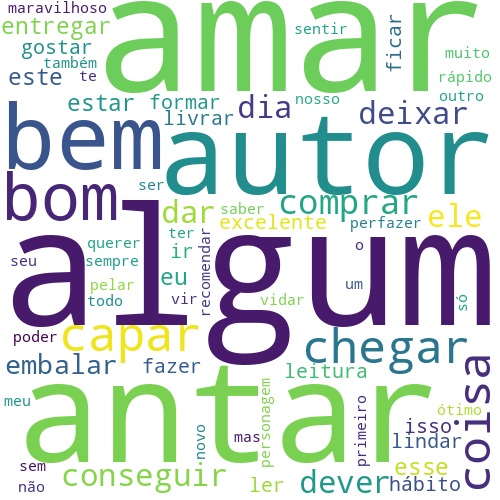

In [39]:
wordsBowTokenFrequency = ','.join( list(dfBowTokenFrequency.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTokenFrequency )
wordcloud.to_image()

### BoW - Sparse Matrix - Binary

In [40]:
%%time

vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    ngram_range=(1,1),
    binary=True,
    max_df = max_df,
    min_df = min_df)

dfBowBinary = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowBinary.head(20)

CPU times: user 4.6 s, sys: 8.27 ms, total: 4.61 s
Wall time: 4.61 s


,algum,amar,antar,at,autor,bem,bom,capar,chegar,coisa,...,seu,só,também,te,ter,todo,um,vidar,vir,ótimo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
print( f'Number of columns: {len( dfBowBinary.columns)}' )

Number of columns: 67


### BoW - Sparse Matrix - TF-IDF

https://www.kaggle.com/code/k4puneet/countvectorizer-tfidf-tutorial/notebook

#### TfidfVectorizer

In [42]:
%%time

vectorizer = TfidfVectorizer( 
    analyzer = tokenizer,
    max_df = max_df,
    min_df = min_df)

dfBowTFIDF = pd.DataFrame(
    data = vectorizer.fit_transform( partialDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTFIDF.head(20)

CPU times: user 4.53 s, sys: 4.18 ms, total: 4.54 s
Wall time: 4.54 s


,algum,amar,antar,at,autor,bem,bom,capar,chegar,coisa,...,seu,só,também,te,ter,todo,um,vidar,vir,ótimo
0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
1,0.591498,0.0,0.0,0.0,0.51917,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
2,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
3,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
4,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
5,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
6,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
7,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
8,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
9,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0


In [43]:
print( f'Number of columns: {len( dfBowTFIDF.columns )}' )

Number of columns: 67


### Total of clusters

In [44]:
clustersTotal = 3

### Function: classReport

In [45]:
def classReport( columnLabel, clustersTotal ):

    for i in range(0, clustersTotal):

        print( '===========================================================================' )
        print( f'Representation: {columnLabel} - class: {i}' )
        print( '===========================================================================' )
        print()

        dfClass = partialDf[ partialDf[ columnLabel ] == i ]

        display( dfClass.head(10) )
        print()

        print( f'Sentences by score from class {i}' )
        print( '====================================' )
        print( dfClass[ 'review_rating' ].value_counts().sort_index( ascending=False ) )
        print()

        print( f'Examples from class {i}' )
        print( '====================================' )
        print()

        if len( dfClass['sentence'] ) >= 5:
            sentencesClass = dfClass['sentence'].sample(5)
            for sentence in sentencesClass:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
        else:
            for sentence in dfClass['sentence']:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
                

        print( '###########################################################################' )
        print( '###########################################################################' )
        print( '###########################################################################' )
        print()

### K-Means - BoW - Sparse Matrix - Token Frequency

In [46]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTokenFrequency )
kmeans

KMeans(n_clusters=3, random_state=0)

#### Labels and Centroids

In [47]:
kmeans.labels_

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,

In [48]:
kmeans.cluster_centers_

array([[ 5.88235294e-02,  2.35294118e-02,  1.64705882e-01,
         2.35294118e-02, -2.08166817e-17,  4.11764706e-01,
         9.41176471e-02,  3.52941176e-02,  7.76470588e-01,
        -6.93889390e-18,  8.23529412e-02, -3.46944695e-18,
         1.17647059e-02, -6.93889390e-18, -6.93889390e-18,
         2.11764706e-01,  4.70588235e-02,  2.35294118e-01,
         1.05882353e-01,  1.17647059e-02,  3.76470588e-01,
        -3.46944695e-18,  4.70588235e-02,  2.35294118e-02,
         1.17647059e-02,  2.35294118e-02,  1.17647059e-02,
         3.52941176e-02, -3.46944695e-18, -1.38777878e-17,
         3.52941176e-02,  1.17647059e-02,  1.41176471e-01,
         9.41176471e-02,  8.23529412e-02,  1.17647059e-02,
         1.17647059e-02,  8.23529412e-02,  1.17647059e-02,
         1.17647059e-02, -6.93889390e-18,  1.05882353e-01,
         3.52941176e-02,  2.35294118e-02,  1.17647059e-02,
         2.00000000e-01,  1.17647059e-02,  1.17647059e-02,
         1.17647059e-02,  3.52941176e-02,  5.88235294e-0

In [49]:
columnLabel = 'class__bow_token_frequency'

In [50]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2


In [51]:
partialDf[columnLabel].value_counts().sort_index()

0     85
1    726
2    189
Name: class__bow_token_frequency, dtype: int64

#### PCA

In [52]:
%%time

pcaBowTokenFrequency = PCA( n_components=2 )
principalComponentsBowTokenFrequency = pcaBowTokenFrequency.fit_transform( dfBowTokenFrequency )
# principalComponentsBowTokenFrequency
# type(principalComponentsBowTokenFrequency)

CPU times: user 64.5 ms, sys: 68 ms, total: 132 ms
Wall time: 50.8 ms


In [53]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponentsBowTokenFrequency:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

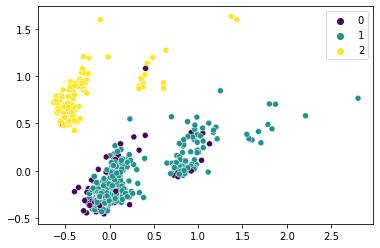

In [54]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [55]:
%%time

mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowTokenFrequency )
mds.shape

CPU times: user 59.2 s, sys: 33.1 s, total: 1min 32s
Wall time: 24.6 s


(1000, 2)

In [56]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

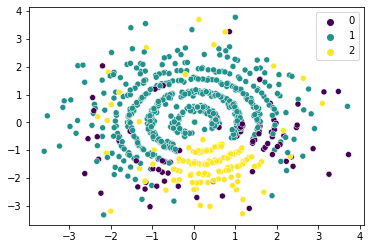

In [57]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [58]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTokenFrequency )
tsne.shape

CPU times: user 15.6 s, sys: 135 ms, total: 15.7 s
Wall time: 4.17 s


(1000, 2)

In [59]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

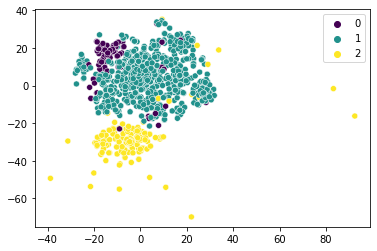

In [60]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [61]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_token_frequency - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency
43546,8501117684,R3GEMWQ96YK3LW,3,confesso estava extremamente receosa pois vi m...,190,0
11371,8550802751,R32HR9M1LNXWPR,5,algumas regras soaram bem estranhas desconexas...,160,0
136602,8543109701,R2Q5AQ8S9CNUNG,2,meu chegou páginas faltando,27,0
20112,8584391509,RXXTOBBUHQPYL,5,livro perfeito bem embalado entrega foi rápida,46,0
76367,6555650001,RDIKQ0OPY9ZJM,5,chegou muuuuuito rápido,23,0
171796,8565765695,R1WVZXRT1QHCGS,5,fora q chega rápido,19,0
73090,8555340896,R2KBGWG9NAXW2S,5,chegou bem embalado rápido perfeitas condições,46,0
171549,8565765695,R1033O3RWQE2QV,5,livro incrível desfecho bom goatei demais veio...,65,0
138642,8565765482,R15SDLA951P5FZ,5,já li perfeito chegou certinho aqui vale apena...,64,0
52956,8595084742,R1E05P3T786LNA,5,demorou pouquinho chegar chegou ótimas condições,48,0



Sentences by score from class 0
5    68
4     8
3     7
2     2
Name: review_rating, dtype: int64

Examples from class 0

eu estou prólogo ainda veio perfeito estado 

-----------------------------------

amei livroveio perfeito estado borda estava meio dobrada nada veio incomodar incrível e

-----------------------------------

chegou dia certinho bem embalado

-----------------------------------

livro queria chegou beeem antes prazo acabamento colagem perfeitaobrigada prestatividade

-----------------------------------

veio extremamente bem empacotado sem arranhão sequer

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_token_frequency - class: 1



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1
5234,8501112518,RCRRN86XRURME,5,sinceramente fiquei eufórica quando terminei q...,148,1
128837,8584391673,R1UVDEELCL4YWI,4,ele cara generoso apaixonado compreensivo pass...,60,1
69008,8535909559,R3W4BENG7KV4BV,3,assim vai concretizando república bichos,40,1
150478,8580412382,RDZ60QFR07RKH,5,impossível não render narrativa dela,36,1
22903,8595083274,R2AZVE29DMND1A,5,esse deveria distribuído escolas,32,1
155581,6599039812,R1T9OIVUPBD4ZD,3,aliás curiosamente definição personagenspacien...,66,1



Sentences by score from class 1
5    568
4     81
3     44
2     11
1     22
Name: review_rating, dtype: int64

Examples from class 1

impossível não impactado leitura

-----------------------------------

livro excelente traz ensinamentos vida

-----------------------------------

ouvi muita gente dizer não gostou deste série minha opinião outra 

-----------------------------------

um precioso

-----------------------------------

primeiro pague si depois aos outros

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_token_frequency - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2
51731,8595084742,RN08NE2QK54OM,5,o hobbit conto responsável dar início à terra ...,111,2
166257,8535932879,R3UDWUXDPG3RZR,5,a única raça há humana,22,2
83884,8543102146,R15HGZXD4WMXTN,5,o estresse falta propósito ocorrem quando gent...,72,2
144566,8576849941,R1WBO71263AK05,4,a ideia si legal nao serve todas pessoas,40,2
165580,8594541473,R1UAWBPWUEO63F,5,as histórias bem explicativas assassinas época,46,2
27102,8538058975,R2Y2GRQBZGLWCM,5,o traz adulto reflexão rotulamos coloca crianç...,111,2
81424,8575422391,RUKSYKJ2XVL2X,4,o veio parte danificada,23,2
32230,6580309318,R2I9PHP4AUSYCF,5,o texto cinematográfico pungente carregado det...,69,2
128859,8584391673,R2IAHF5LPJIXWK,5,o final foi imagina torcia então fiquei feliz,45,2



Sentences by score from class 2
5    134
4     29
3     10
2      7
1      9
Name: review_rating, dtype: int64

Examples from class 2

o venho perfeito estado

-----------------------------------

no refere conteúdo estou maravilhada

-----------------------------------

o veio parte danificada

-----------------------------------

o conteúdo série fiz isso isso leitor acredite autor especialista algo final dá dicas óbvias seja próativo estude seja bem educado pense positivo aí larga historinhas ajudou longo vida

-----------------------------------

a consciência adquirida nosso comportamento após leitura excepcional

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



### K-Means - BoW - Sparse Matrix - Binary

In [62]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowBinary )
kmeans

KMeans(n_clusters=3, random_state=0)

#### Labels and Centroids

In [63]:
kmeans.labels_

array([1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2,

In [64]:
kmeans.cluster_centers_

array([[ 2.08333333e-02,  5.20833333e-02,  5.20833333e-02,
         2.08333333e-02,  3.12500000e-02,  9.37500000e-02,
         8.33333333e-02,  2.08333333e-02,  1.66666667e-01,
         1.04166667e-02,  4.16666667e-02,  4.16666667e-02,
         1.04166667e-02, -6.93889390e-18, -3.46944695e-18,
         5.20833333e-02,  3.12500000e-02,  3.12500000e-02,
         3.12500000e-02,  1.04166667e-02,  1.00000000e+00,
         1.04166667e-02,  4.16666667e-02,  2.08333333e-02,
         1.04166667e-01,  3.12500000e-02,  3.12500000e-02,
         5.20833333e-02, -3.46944695e-18,  1.04166667e-02,
         6.25000000e-02,  8.33333333e-02,  1.77083333e-01,
         5.20833333e-02,  5.20833333e-02,  2.08333333e-02,
         3.12500000e-02,  7.29166667e-02,  3.12500000e-02,
         5.20833333e-02, -3.46944695e-18,  1.77083333e-01,
         2.50000000e-01,  2.08333333e-02,  3.12500000e-02,
         1.56250000e-01,  4.16666667e-02,  2.08333333e-02,
         3.12500000e-02,  3.12500000e-02,  4.16666667e-0

In [65]:
columnLabel = 'class__bow_binary'

In [66]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1,1
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1,1
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1,1
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1,1
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2,2


In [67]:
partialDf[columnLabel].value_counts().sort_index()

0     96
1    736
2    168
Name: class__bow_binary, dtype: int64

#### PCA

In [68]:
%%time

pcaBowBinary = PCA( n_components=2 )
principalComponentsBowBinary = pcaBowBinary.fit_transform( dfBowBinary )
# principalComponentsBowBinary
# type(principalComponentsBowBinary)

CPU times: user 65.8 ms, sys: 67.2 ms, total: 133 ms
Wall time: 59.6 ms


In [69]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponentsBowBinary:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

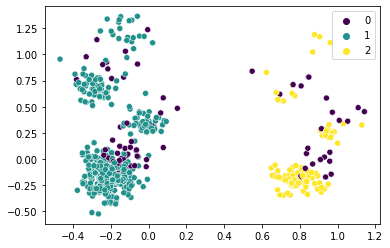

In [70]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [71]:
%%time

mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowBinary )
mds.shape

CPU times: user 59.7 s, sys: 34.7 s, total: 1min 34s
Wall time: 26.3 s


(1000, 2)

In [72]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

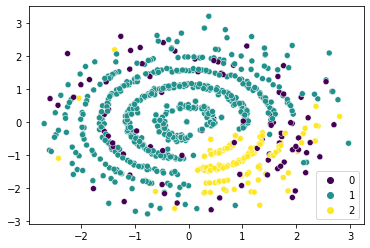

In [73]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [74]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowBinary )
tsne.shape

CPU times: user 14.9 s, sys: 93.6 ms, total: 15 s
Wall time: 3.94 s


(1000, 2)

In [75]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

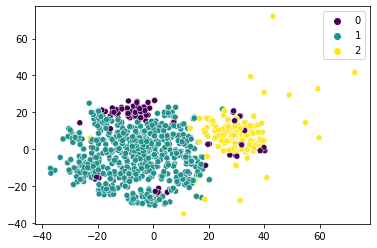

In [76]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [77]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_binary - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary
5234,8501112518,RCRRN86XRURME,5,sinceramente fiquei eufórica quando terminei q...,148,1,0
43546,8501117684,R3GEMWQ96YK3LW,3,confesso estava extremamente receosa pois vi m...,190,0,0
18211,8584391509,R2R4LOX3TX8M53,4,mas não gostei final prefiro não mencionalo al...,87,1,0
11371,8550802751,R32HR9M1LNXWPR,5,algumas regras soaram bem estranhas desconexas...,160,0,0
20131,8584391509,R20FPW2ZUCRGAJ,5,estou amando veio certo,23,1,0
134726,8543105293,R1D09XS34YZ63V,5,muitas reflexões importantes vida seus momento...,72,1,0
76316,6555650001,R3MCBYHPV8VKEC,5,me apaixonei edição estou ansiosa lêlo,38,1,0
25290,8595083274,R1TN2DMYBTLWUR,5,já estou economizando kkkkkk,28,1,0
150682,8580412382,R187APDZNXQPC0,5,estou solução encantada benedict,33,1,0
123629,8551006754,R2MWPF4FP8JIB1,3,a edição desse está linda porém não veio marca...,94,2,0



Sentences by score from class 0
5    73
4     9
3    10
2     2
1     2
Name: review_rating, dtype: int64

Examples from class 0

meu primeiro colleen hoover estou completamente apaixonada

-----------------------------------

sinceramente fiquei eufórica quando terminei queria entrar dentro bater personagens😹😹 enquanto estava lendo senti vibes crepúsculo porém amadurecida

-----------------------------------

estou completamente apaixonada raissa ayla

-----------------------------------

foi ela pediu presente aniversário chegou bem antes prazo perfeito estado

-----------------------------------

estou apaixonada neste capa

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_binary - class: 1



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1,1
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1,1
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1,1
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1,1
128837,8584391673,R1UVDEELCL4YWI,4,ele cara generoso apaixonado compreensivo pass...,60,1,1
69008,8535909559,R3W4BENG7KV4BV,3,assim vai concretizando república bichos,40,1,1
150478,8580412382,RDZ60QFR07RKH,5,impossível não render narrativa dela,36,1,1
22903,8595083274,R2AZVE29DMND1A,5,esse deveria distribuído escolas,32,1,1
155581,6599039812,R1T9OIVUPBD4ZD,3,aliás curiosamente definição personagenspacien...,66,1,1
17295,8584391509,RIOJNMQ8EMBMN,5,tenho certeza vai virar clássico,32,1,1



Sentences by score from class 1
5    575
4     83
3     45
2     12
1     21
Name: review_rating, dtype: int64

Examples from class 1

ensina muda tua vida

-----------------------------------

oi moçamesmo homem tive dificuldades aceitar estas situações

-----------------------------------

qualquer coisa menos isso recebe resposta negativaconfesso depois terminei senti inspirado fazer limpeza minhas coisas

-----------------------------------

linda mensagem transmite

-----------------------------------

livro leitura obrigatória

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_binary - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2,2
51731,8595084742,RN08NE2QK54OM,5,o hobbit conto responsável dar início à terra ...,111,2,2
166257,8535932879,R3UDWUXDPG3RZR,5,a única raça há humana,22,2,2
83884,8543102146,R15HGZXD4WMXTN,5,o estresse falta propósito ocorrem quando gent...,72,2,2
144566,8576849941,R1WBO71263AK05,4,a ideia si legal nao serve todas pessoas,40,2,2
165580,8594541473,R1UAWBPWUEO63F,5,as histórias bem explicativas assassinas época,46,2,2
27102,8538058975,R2Y2GRQBZGLWCM,5,o traz adulto reflexão rotulamos coloca crianç...,111,2,2
81424,8575422391,RUKSYKJ2XVL2X,4,o veio parte danificada,23,2,2
32230,6580309318,R2I9PHP4AUSYCF,5,o texto cinematográfico pungente carregado det...,69,2,2
128859,8584391673,R2IAHF5LPJIXWK,5,o final foi imagina torcia então fiquei feliz,45,2,2



Sentences by score from class 2
5    122
4     26
3      6
2      6
1      8
Name: review_rating, dtype: int64

Examples from class 2

o poderia reduzido consideravelmente

-----------------------------------

o veio sem defeitos bem embalado

-----------------------------------

a premissa foi interessante misturar elementos contos fadas realidade atual meio viés feminista

-----------------------------------

o veio bonitinho caixa bem protegido

-----------------------------------

o começa intenso alguma maneira fim não tão intenso deixando vontade ação detalhes

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



### K-Means - BoW - Sparse Matrix - TF-IDF

In [78]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTFIDF )
kmeans

KMeans(n_clusters=3, random_state=0)

#### Labels and Centroids

In [79]:
kmeans.labels_

array([1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,

In [80]:
kmeans.cluster_centers_

array([[ 1.57021622e-02,  2.15780188e-02,  1.43335571e-02,
         1.41639317e-02,  2.29558790e-02,  3.40982894e-02,
         3.48477960e-02,  1.40593115e-02,  4.12673210e-02,
         1.32854409e-02,  2.24041076e-02,  1.41979777e-02,
         2.14163094e-02,  1.42456196e-02,  1.37153932e-02,
         2.55178110e-02,  2.10902620e-02,  1.55715579e-02,
         1.44439482e-02,  1.70055237e-02,  4.27701160e-02,
         1.82777661e-02,  1.59366383e-02,  1.28883588e-02,
         3.07619756e-02,  1.32826826e-02,  1.99988049e-02,
         2.45787616e-02,  9.50585312e-03,  2.05627527e-02,
         1.69602880e-02,  1.95380254e-03,  4.09409379e-02,
         1.31562790e-02,  4.09658036e-02,  1.41727376e-02,
         2.12884217e-02,  2.80358561e-02,  2.28378944e-02,
         2.21497202e-02,  1.26752840e-02,  6.23707323e-02,
         4.75459655e-03,  1.45440318e-02,  1.41523715e-02,
         1.96143999e-02,  1.41197851e-02,  2.43455707e-02,
         1.56547338e-02,  2.56095803e-02,  2.13655460e-0

In [81]:
columnLabel = 'class__bow_tfidf'

In [82]:
partialDf[columnLabel] = kmeans.labels_
partialDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1,1,1
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1,1,0
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1,1,0
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1,1,1
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2,2,2


In [83]:
partialDf[columnLabel].value_counts().sort_index()

0    752
1     81
2    167
Name: class__bow_tfidf, dtype: int64

#### PCA

In [84]:
%%time

pca = PCA( n_components=2 )
principalComponents = pca.fit_transform( dfBowTFIDF )

CPU times: user 110 ms, sys: 79.2 ms, total: 189 ms
Wall time: 67.8 ms


In [85]:
'''
array([[ 1.21904561e+00, -1.18886035e+00],
       [ 2.39121079e-01, -3.42411365e-01],
       [-1.36406682e-01,  6.55526438e-01],
'''

a = []
b = []
for item in principalComponents:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

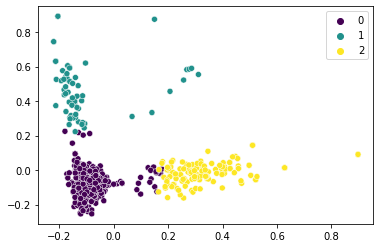

In [86]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### MDS

In [87]:
%%time

mds = MDS(n_components=2)
mds = mds.fit_transform( dfBowTFIDF )
mds.shape

CPU times: user 59.2 s, sys: 32.6 s, total: 1min 31s
Wall time: 24 s


(1000, 2)

In [88]:
a = []
b = []
for item in mds:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

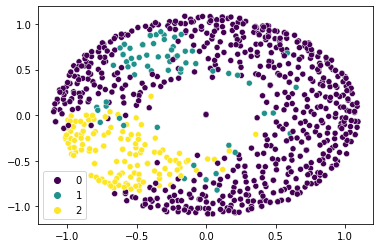

In [89]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### TSNE

In [90]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTFIDF )
tsne.shape

CPU times: user 14.1 s, sys: 158 ms, total: 14.2 s
Wall time: 3.67 s


(1000, 2)

In [91]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

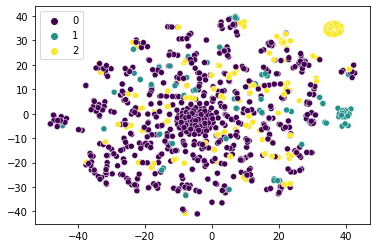

In [92]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [93]:
classReport( columnLabel, clustersTotal )

Representation: class__bow_tfidf - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
115396,8582892101,RU0HK75NUE4U6,5,como próprio autor deixa claro início velhas a...,114,1,1,0
64732,8535909559,R27BYCSQB6FDJO,4,pra leu vai identificar vários elementos simil...,80,1,1,0
5234,8501112518,RCRRN86XRURME,5,sinceramente fiquei eufórica quando terminei q...,148,1,0,0
128837,8584391673,R1UVDEELCL4YWI,4,ele cara generoso apaixonado compreensivo pass...,60,1,1,0
69008,8535909559,R3W4BENG7KV4BV,3,assim vai concretizando república bichos,40,1,1,0
150478,8580412382,RDZ60QFR07RKH,5,impossível não render narrativa dela,36,1,1,0
22903,8595083274,R2AZVE29DMND1A,5,esse deveria distribuído escolas,32,1,1,0
43546,8501117684,R3GEMWQ96YK3LW,3,confesso estava extremamente receosa pois vi m...,190,0,0,0
155581,6599039812,R1T9OIVUPBD4ZD,3,aliás curiosamente definição personagenspacien...,66,1,1,0
17295,8584391509,RIOJNMQ8EMBMN,5,tenho certeza vai virar clássico,32,1,1,0



Sentences by score from class 0
5    584
4     84
3     49
2     14
1     21
Name: review_rating, dtype: int64

Examples from class 0

ele repete veio páginas repetidas

-----------------------------------

fábula extraordinária

-----------------------------------

aqui adoraram

-----------------------------------

queremos tenham

-----------------------------------

enquanto lia pensava algumas vezes:

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_tfidf - class: 1



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
134798,8543105293,R1NBV6CC49BWNG,5,leitura agradável fácil entendimento atendeu m...,62,1,1,1
43205,8568014542,RP73OGGGL4QUY,5,leitura flui naturalmente napoleon hill,39,1,1,1
11371,8550802751,R32HR9M1LNXWPR,5,algumas regras soaram bem estranhas desconexas...,160,0,0,1
80002,8575422391,RMCOJFL7UB3T9,5,livro leitura obrigatório pelo menos vez ano,44,1,1,1
134726,8543105293,R1D09XS34YZ63V,5,muitas reflexões importantes vida seus momento...,72,1,0,1
166976,8535932879,R16KJXS1EJ5PCY,5,leitura fácil agradável traz muitos elementos ...,133,1,1,1
117100,8532530788,R1ZC01OZ0GP1PP,5,livro bem embalado leitura tranquila,36,1,1,1
61837,8546501459,R25XFDABF2KJ9R,5,tive receio leitura tornar cansativa não acont...,50,1,1,1
19204,8584391509,R12HW1HA1H54OW,5,a principio pensei seria leitura chata at come...,120,2,2,1
37966,8547000240,R2FIXDFK47O85M,5,livro fácil leitura ilustrada exemplos famosos...,64,1,1,1



Sentences by score from class 1
5    69
4     8
3     2
1     2
Name: review_rating, dtype: int64

Examples from class 1

a principio pensei seria leitura chata at comecei mergulhar historia fiquei apaixonada evelyn hugo sensacional recomendo

-----------------------------------

algumas regras soaram bem estranhas desconexas realidade ridículas falar verdade longo leitura capítulos percebe estão intrinsicamente ligadas objetivo proposto

-----------------------------------

recomendoo leitura rapida facil

-----------------------------------

leitura gratificante edificante

-----------------------------------

foi leitura gostosa excesso açúcar daqueles

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class__bow_tfidf - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,class__bow_token_frequency,class__bow_binary,class__bow_tfidf
123306,8551006754,RJL7Y2HNOBTRM,5,o produto lindo rico detalhe ilustrações incrí...,50,2,2,2
51731,8595084742,RN08NE2QK54OM,5,o hobbit conto responsável dar início à terra ...,111,2,2,2
166257,8535932879,R3UDWUXDPG3RZR,5,a única raça há humana,22,2,2,2
83884,8543102146,R15HGZXD4WMXTN,5,o estresse falta propósito ocorrem quando gent...,72,2,2,2
144566,8576849941,R1WBO71263AK05,4,a ideia si legal nao serve todas pessoas,40,2,2,2
165580,8594541473,R1UAWBPWUEO63F,5,as histórias bem explicativas assassinas época,46,2,2,2
27102,8538058975,R2Y2GRQBZGLWCM,5,o traz adulto reflexão rotulamos coloca crianç...,111,2,2,2
81424,8575422391,RUKSYKJ2XVL2X,4,o veio parte danificada,23,2,2,2
32230,6580309318,R2I9PHP4AUSYCF,5,o texto cinematográfico pungente carregado det...,69,2,2,2
128859,8584391673,R2IAHF5LPJIXWK,5,o final foi imagina torcia então fiquei feliz,45,2,2,2



Sentences by score from class 2
5    117
4     26
3     10
2      6
1      8
Name: review_rating, dtype: int64

Examples from class 2

o excelente começo fim cheio reviravoltas muita ação

-----------------------------------

a nova sociedade criada pelos animais aqui perfeitamente bem construída desenvolvida passar críticas sociais ficam vez gritantes

-----------------------------------

no refere conteúdo estou maravilhada

-----------------------------------

a melhor edição de

-----------------------------------

a edição desse está linda porém não veio marcador páginas conforme anúncio propaganda enganosa

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



## LDA - BoW - Sparse Matrix - Token Frequency

"By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight"
From: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [94]:
# ldaPartialDf = [ str(sentence).encode("utf-8") for sentence in partialDf['sentence'] ]
# # ldaPartialDf = [ u''.join( str(sentence) ) for sentence in partialDf['sentence'] ]

# ldaPartialDf[ 0 ]

In [95]:
type( partialDf['sentence'].tolist() )

list

In [96]:
# Based on 
# https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
doc_tokenized = [ simple_preprocess( str(sentence) ) for sentence in partialDf['sentence'].tolist() ]
dictionary = Dictionary()
BoW_corpus = [ dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized ]
# print(BoW_corpus)

In [97]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [98]:
lda_model = LdaModel(
    corpus=BoW_corpus,
    id2word=dictionary,
    num_topics=clustersTotal)
pprint(lda_model.print_topics())
# doc_lda = lda_model[BoW_corpus]

[(0,
  '0.022*"não" + 0.012*"leitura" + 0.011*"livro" + 0.008*"vida" + 0.007*"veio" '
  '+ 0.007*"bem" + 0.004*"bom" + 0.004*"li" + 0.004*"te" + 0.004*"minha"'),
 (1,
  '0.010*"foi" + 0.007*"chegou" + 0.006*"leitura" + 0.006*"perfeito" + '
  '0.006*"bem" + 0.005*"não" + 0.005*"vida" + 0.005*"livro" + 0.004*"estou" + '
  '0.004*"autor"'),
 (2,
  '0.011*"não" + 0.009*"bem" + 0.007*"chegou" + 0.006*"sem" + 0.005*"leitura" '
  '+ 0.005*"forma" + 0.005*"bom" + 0.004*"lindo" + 0.004*"um" + 0.004*"ótimo"')]
